# MobileNetv2+SSD with hypermodel<br>

(source  https://github.com/saunack/MobileNetv2-SSD/blob/master/model.ipynb)
This is an implementation of the MobileNetv2 + SSD architecture for a relatively simpler task of determining bounding boxes for MNIST images embedded in a box. Each box contains only one digit(28x28 MNIST embedded into a 224x224 box) as of now, but the number of predictions per image can be expanded easily (the training outputs need to modified). Also, no data augmentation has been used till now (Colab kept crashing when I increased the dataset size beyond 1000, so the initial amount of data present was sufficient. The crashes might have been due to high traffic, but I haven't confirmed it).<p>
In the earlier implementation, the ground truth data contained information about only one bounding box, which meant only one prediction per image (reference in README). For me, it also reduced the training signal and the model was overfitting. So I changed the outputs to a prediction for each default box (as it should be, from what I understood from the SSD paper). Although the initial implementation is good for the purposes for understanding the model.

Comments mentioned throughout the code mention what needs to change if the model inputs or outputs are changed.

Import libraries

In [1]:
!pip install keras==2.8 bottleneck

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 355 kB 35.0 MB/s 


In [1]:


from __future__ import absolute_import, division, print_function
#from model_all import SqueezeNetModel, SqueezeNet11Model, SqueezeNetSEAutoModel
from keras_tuner import RandomSearch, BayesianOptimization, Hyperband

from random import randint, choices, shuffle
from random import seed
from keras_tuner.engine import hypermodel
from keras_tuner import HyperParameters, Objective
from keras_tuner import HyperModel
from keras_tuner import HyperParameters
import tensorflow.keras.backend as K
import cv2
from tensorflow import keras

import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



In [2]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import numpy.matlib
from PIL import Image
from keras import backend as K
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import bottleneck

In [3]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.measure import find_contours
from skimage.util import invert
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
plt.style.use('default')

import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
#from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer

from IPython.display import Image,display
from PIL import Image as Img
import tensorflow as tf

import yaml

In [4]:
tf.compat.v1.enable_eager_execution()

# Build model

Define Bottleneck Residual layer for MobileNet<br>
Using the same parameters as mentioned in the paper

In [5]:
class Bottleneck(keras.Model):
  def __init__(
      self,
      expansion,
      stride,
      block_id,
      filters,
      alpha=1,
      ):
    super(Bottleneck,self).__init__(name = "Bottleneck_" + block_id)
    self.stride = stride
    self.expansion = expansion
    self.alpha = alpha
    self.output_channels = self.alpha * filters
    self.out = None # there was some problem with the eager execution

    prefix =  'Bottleneck_{}_'.format(block_id)
    self.prefix = prefix
    # expansion
    self.expand_BN = layers.BatchNormalization(name = prefix + 'expand_BN')
    self.expand_ReLU = layers.ReLU(max_value=6, name = prefix + 'expand_ReLU')

    #conv
    self.Conv = layers.DepthwiseConv2D(
        kernel_size = 3,
        padding='same',
        strides = self.stride,
        use_bias = False,
        name = prefix + 'conv')
    self.Conv_BN = layers.BatchNormalization(name = prefix + 'conv_BN')
    self.Conv_ReLU = layers.ReLU(max_value=6, name = prefix + 'conv_ReLU')

    #project
    self.project = layers.Conv2D(
        filters = self.output_channels,
        kernel_size = 1,
        use_bias = False,
        name = 'contract')
    self.project_BN = layers.BatchNormalization(name = prefix + 'contract_BN')

    # dimensions need to be the same for residual connection
    self.residual = layers.Add(name=prefix + 'residual')
  
  def build(self, input_shape):
    self.d = input_shape[-1]
    
    self.expand = layers.Conv2D(
        filters = self.expansion*self.d,
        kernel_size = 1,
        use_bias = False,
        name = self.prefix+'expand')

      
  def call(self, inputs):

    x = self.expand(inputs)
    x = self.expand_BN(x)
    x = self.expand_ReLU(x)
    self.out = x
    
    x = self.Conv(x)
    x = self.Conv_BN(x)
    x = self.Conv_ReLU(x)

    x = self.project(x)
    x = self.project_BN(x)

    if self.output_channels == self.d and self.stride == 1:
      x = self.residual([inputs,x])

    return x

  def model(self):
      x = keras.Input(shape=(28,28,3))
      return keras.Model(inputs=[x], outputs=self.call(x))

## Define MobileNetv2<br>
Same components as mentioned in the paper (the input image dimensions are a bit different)


In [6]:
#using the architecture mentioned in the paper
class MobileNetv2(keras.Model):
  def __init__(self, k = 11):
    super(MobileNetv2,self).__init__()
    self.conv_inp = layers.Conv2D(
        filters = 32,
        kernel_size = 3,
        strides = (2,2),
        padding='valid',
        use_bias = False,
        name = 'conv'
    )
    self.k = k    

    self.pad = layers.ZeroPadding2D(padding=2,name='pad')
    self.BN = layers.BatchNormalization(name='BN')
    self.ReLU = layers.ReLU(max_value = 6, name = 'ReLU')
    
    self.B1_1 = Bottleneck(expansion = 1, filters = 16, stride = 1, block_id = 'B1_1')

    self.B2_1 = Bottleneck(expansion = 6, filters = 24, stride = 2, block_id = 'B2_1')
    self.B2_2 = Bottleneck(expansion = 6, filters = 24, stride = 1, block_id = 'B2_2')

    self.B3_1 = Bottleneck(expansion = 6, filters = 32, stride = 2, block_id = 'B3_1')
    self.B3_2 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_2')
    self.B3_3 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_3')

    self.B4_1 = Bottleneck(expansion = 6, filters = 64, stride = 2, block_id = 'B4_1')
    self.B4_2 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_2')
    self.B4_3 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_3')
    self.B4_4 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_4')

    self.B5_1 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_1')
    self.B5_2 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_2')
    self.B5_3 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_3')

    self.B6_1 = Bottleneck(expansion = 6, filters = 160, stride = 2, block_id = 'B6_1')
    self.B6_2 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_2')
    self.B6_3 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_3')

    self.B7_1 = Bottleneck(expansion = 6, filters = 320, stride = 1, block_id = 'B7_1')

    self.conv_out = layers.Conv2D(
        filters = 1280,
        kernel_size = 1,
        strides = (1,1),
        use_bias = False,
        name = 'conv_out'
    )
    self.avgpool = layers.AveragePooling2D(
        pool_size = (7,7),
        name='avg_pool'
        )
    
    self.conv_seg = layers.Conv2D(
        filters = self.k,
        kernel_size = 1,
        strides = (1,1),
        use_bias = False,
        name = 'conv_seg'
    )

  def call(self, inputs):
    x = self.conv_inp(inputs)
    x = self.BN(x)
    x = self.ReLU(x)

    x = self.B1_1(x)
    x = self.B2_1(x)
    x = self.B2_2(x)

    x = self.B3_1(x)
    x = self.B3_2(x)
    x = self.B3_3(x)
    
    x = self.B4_1(x)
    x = self.B4_2(x)
    x = self.B4_3(x)
    x = self.B4_4(x)
    
    x = self.B5_1(x)
    x = self.B5_2(x)
    x = self.B5_3(x)
    
    x = self.B6_1(x)
    x = self.B6_2(x)
    x = self.B6_3(x)
    
    x = self.B7_1(x)

    x = self.conv_out(x)
    x = self.avgpool(x)
    c4 = self.conv_seg(x)

    return c4

  def model(self):
      x = keras.Input(shape=(224,224,3))

      return keras.Model(inputs=x, outputs=self.call(x))

In [7]:
model_mobilenet = MobileNetv2().model()
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv (Conv2D)               (None, 111, 111, 32)      864       
                                                                 
 BN (BatchNormalization)     (None, 111, 111, 32)      128       
                                                                 
 ReLU (ReLU)                 (None, 111, 111, 32)      0         
                                                                 
 Bottleneck_B1_1 (Bottleneck  (None, 111, 111, 16)     2144      
 )                                                               
                                                                 
 Bottleneck_B2_1 (Bottleneck  (None, 56, 56, 24)       5568      
 )                                                           

## Defining SSD<br>
The default number of boxes per layer and resolution of each layer is different, since we are working with MNIST data and 224x224 image sizes.<p>
To change the number of boxes per layer and layerWidths, some constraints need to be kept in mind which are mentioned in the later sections

In [8]:
class SSD(keras.Model):
  def __init__(self, numBoxes=[4,6,6,6,4,4], layerWidth=[28,14,7,4,2,1], k = 10+1+4):
    super(SSD,self).__init__()
    self.classes = k
    self.featureMaps = 6
    self.MobileNet = MobileNetv2(k=k)

    # mark bottleneck_6_1 onwards as non trainable
    for layer in self.MobileNet.layers[-7:]:
      layer.trainable=False
    
    # For bottleneck_5_3, mark layers beyond conv as non runnable
    # layers in bottleneck_5_3: ['Bottleneck_B5_3_expand_BN', 'Bottleneck_B5_3_expand_ReLU', 'Bottleneck_B5_3_conv', 'Bottleneck_B5_3_conv_BN', 
    # 'Bottleneck_B5_3_conv_ReLU', 'contract', 'Bottleneck_B5_3_contract_BN', 'Bottleneck_B5_3_residual', 'Bottleneck_B5_3_expand']
    for layer in self.MobileNet.layers[-8].layers[2:-1]:
      layer.trainable=False

    self.numBoxes = numBoxes
    self.layerWidth = layerWidth
    self.features = [None for _ in range(self.featureMaps)]
    self.classifiers = [None for _ in range(self.featureMaps)]
    
    self.conv1_1 = layers.Conv2D(256,1,name='SSD_conv_1_1')
    self.conv1_2 = layers.Conv2D(512,3,strides=(2,2),padding='same',name='SSD_conv_1_2')

    self.conv2_1 = layers.Conv2D(128,1,name='SSD_conv_2_1')
    self.conv2_2 = layers.Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_2_2')
    
    self.conv3_1 = layers.Conv2D(128,1,name='SSD_conv_3_1')
    self.conv3_2 = layers.Conv2D(256,3,strides=(1,1),name='SSD_conv_3_2')
    
    self.conv4_1 = layers.Conv2D(128,1,name='SSD_conv_4_1')
    self.conv4_2 = layers.Conv2D(256,2,strides=(1,1),name='SSD_conv_4_2') # changed the kernel size to 2 since the output of the previous layer has width 3

    self.conv = []
    self.reshape = []
    for i in range(self.featureMaps):
      self.conv.append(layers.Conv2D(self.numBoxes[i]*self.classes,3,padding='same',name='Classification_'+str(i)))
      self.reshape.append(layers.Reshape((self.layerWidth[i]* self.layerWidth[i] * self.numBoxes[i],self.classes),name='Reshape_classification_'+str(i)))

  def build(self, input_shape):
    self.MobileNet.build(input_shape)
  
  def call(self,inputs):
    x = inputs
    x = self.MobileNet(x)

    # get the convolved images at different resolutions
    self.features[0] = self.MobileNet.get_layer('Bottleneck_B4_1').out
    self.features[1] = self.MobileNet.get_layer('Bottleneck_B5_3').out
    self.features[2] = self.conv1_2(self.conv1_1(self.features[1]))
    self.features[3] = self.conv2_2(self.conv2_1(self.features[2]))
    self.features[4] = self.conv3_2(self.conv3_1(self.features[3]))
    self.features[5] = self.conv4_2(self.conv4_1(self.features[4]))

    for i in range(self.featureMaps):
    # for each feature map, create predictions according to the number of boxes for that layer and the number of output channels
      x = self.conv[i](self.features[i])
      x = self.reshape[i](x)
      self.classifiers[i] = x
    
    # concatenate all the classifiers
    x = layers.concatenate(self.classifiers, axis = -2, name='concatenate')
    return x


  def model(self):
      x = keras.Input(shape=(224,224,3))

      return keras.Model(inputs=x, outputs=self.call(x))

In [9]:
NUM_CLASSES = 10
# the first 2 dimensions should be equal to width of the output from the bottleneck expand ReLU at the (4,1) and (5,3) respectively.
# the dimensions after the second one are determined by the convolutions written inside the SSD (conv1_2, conv2_2, conv3_3, conv4_2)
layerWidths = [28,14,7,4,2,1]
numBoxes = [3,3,3,3,3,3]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [10]:
model = SSD(numBoxes=numBoxes, layerWidth=layerWidths, k = outputChannels)
model.model().summary()

TypeError: Exception encountered when calling layer "SSD_conv_1_1" (type Conv2D).

<tf.Tensor 'mobile_netv2_1/Bottleneck_B5_3/Bottleneck_B5_3_expand_ReLU/Relu6:0' shape=(None, 14, 14, 576) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'mobile_netv2_1/Bottleneck_B5_3/Bottleneck_B5_3_expand_ReLU/Relu6:0' shape=(None, 14, 14, 576) dtype=float32> was defined here:
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_8305/3857408409.py", line 2, in <module>
      model.model().summary()
    File "/tmp/ipykernel_8305/1508227539.py", line 70, in model
      return keras.Model(inputs=x, outputs=self.call(x))
    File "/tmp/ipykernel_8305/1508227539.py", line 46, in call
      x = self.MobileNet(x)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1033, in __call__
      input_list)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1174, in _functional_construction_call
      inputs, input_masks, args, kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py", line 897, in _keras_tensor_symbolic_call
      return self._infer_output_signature(inputs, args, kwargs, input_masks)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py", line 942, in _infer_output_signature
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_8305/3997091176.py", line 83, in call
      x = self.B5_3(x)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_8305/1796771022.py", line 58, in call
      x = self.expand_ReLU(x)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/layers/advanced_activations.py", line 436, in call
      threshold=self.threshold)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
      return dispatch_target(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend.py", line 4953, in relu
      x = tf.nn.relu6(x)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
      return dispatch_target(*args, **kwargs)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 3627, in relu6
      return gen_nn_ops.relu6(features, name=name)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 10617, in relu6
      "Relu6", features=features, name=name)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 742, in _apply_op_helper
      attrs=attr_protos, op_def=op_def)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py", line 695, in _create_op_internal
      compute_device)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3784, in _create_op_internal
      op_def=op_def)
    File "/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2175, in __init__
      self._traceback = tf_stack.extract_stack_for_node(self._c_op)

The tensor <tf.Tensor 'mobile_netv2_1/Bottleneck_B5_3/Bottleneck_B5_3_expand_ReLU/Relu6:0' shape=(None, 14, 14, 576) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=mobile_netv2_1_scratch_graph, id=139815210149904), which is out of scope.

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 14, 14, 576), dtype=float32)

## MobileNet Auto

In [11]:
class MobileNetv2Auto(keras.Model):
  def __init__(self,hp, k = 11):
    super(MobileNetv2Auto,self).__init__()
    self.hp = hp
    self.conv_inp = layers.Conv2D(
        filters = 32,
        kernel_size = 3,
        strides = (2,2),
        padding='valid',
        use_bias = False,
        name = 'conv'
    )
    self.k = k    

    self.pad = layers.ZeroPadding2D(padding=2,name='pad')
    self.BN = layers.BatchNormalization(name='BN')
    self.ReLU = layers.ReLU(max_value = 6, name = 'ReLU')
    
    self.B1_1 = Bottleneck(expansion = 1, filters = 16, stride = 1, block_id = 'B1_1')

    self.B2_1 = Bottleneck(expansion = 6, filters = 24, stride = 2, block_id = 'B2_1')
    self.B2_2 = Bottleneck(expansion = 6, filters = 24, stride = 1, block_id = 'B2_2')

    self.B3_1 = Bottleneck(expansion = 6, filters = 32, stride = 2, block_id = 'B3_1')
    self.B3_2 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_2')
    self.B3_3 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_3')

    self.B4_1 = Bottleneck(expansion = 6, filters = 64, stride = 2, block_id = 'B4_1')
    self.B4_2 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_2')
    self.B4_3 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_3')
    self.B4_4 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_4')

    self.B5_1 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_1')
    self.B5_2 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_2')
    self.B5_3 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_3')

    self.B6_1 = Bottleneck(expansion = 6, filters = 160, stride = 2, block_id = 'B6_1')
    self.B6_2 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_2')
    self.B6_3 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_3')

    self.B7_1 = Bottleneck(expansion = 6, filters = 320, stride = 1, block_id = 'B7_1')

    self.conv_out = layers.Conv2D(
        filters = 1280,
        kernel_size = 1,
        strides = (1,1),
        use_bias = False,
        name = 'conv_out'
    )
    self.avgpool = layers.AveragePooling2D(
        pool_size = (7,7),
        name='avg_pool'
        )
    
    self.conv_seg = layers.Conv2D(
        filters = self.k,
        kernel_size = 1,
        strides = (1,1),
        use_bias = False,
        name = 'conv_seg'
    )


            
  def call(self, inputs):
    x = self.conv_inp(inputs)
    x = self.BN(x)
    x = self.ReLU(x)
    
   
    x = self.B1_1(x)
    x = self.B2_1(x)
    x = self.B2_2(x)

    x = self.B3_1(x)
    x = self.B3_2(x)
    #x = self.B3_3(x)
    
    num_repl3 = self.hp.Choice("num_repl3_3", [1,2,3], default=1)
    
    for  i in range(num_repl3):
        x = self.B3_3(x)
        
    x = self.B4_1(x)
    x = self.B4_2(x)
    x = self.B4_3(x)
   
    num_repl4 = self.hp.Choice("num_repl4_4", [1,2,3], default=1)
    
    for  i in range(num_repl4):
        x = self.B4_4(x)
    
    x = self.B5_1(x)
    x = self.B5_2(x)
    #x = self.B5_3(x)
    num_repl5 = self.hp.Choice("num_repl5_3", [1,2,3], default=1)
    
    for  i in range(num_repl5):
        x = self.B5_3(x)
    
    
    
    x = self.B6_1(x)
    x = self.B6_2(x)
    x = self.B6_3(x)
    
    num_repl6 = self.hp.Choice("num_repl6_3", [1,2,3], default=1)
    
    for  i in range(num_repl6):
        x = self.B6_3(x)
    
    x = self.B7_1(x)

    x = self.conv_out(x)
    x = self.avgpool(x)
    c4 = self.conv_seg(x)


    return c4

  def model(self):
    x = keras.Input(shape=(224,224,3))

    return keras.Model(inputs=x, outputs=self.call(x))

## SSD Auto

In [12]:
class SSD_hp(keras.Model):
  def __init__(self, hp,numBoxes=[4,6,6,6,4,4], layerWidth=[28,14,7,4,2,1], k = 10+1+4):
    super(SSD_hp,self).__init__()
    self.classes = k
    self.featureMaps = 6
    self.MobileNet = MobileNetv2Auto(hp,k)

    # mark bottleneck_6_1 onwards as non trainable
    for layer in self.MobileNet.layers[-7:]:
      layer.trainable=False
    
    # For bottleneck_5_3, mark layers beyond conv as non runnable
    # layers in bottleneck_5_3: ['Bottleneck_B5_3_expand_BN', 'Bottleneck_B5_3_expand_ReLU', 'Bottleneck_B5_3_conv', 'Bottleneck_B5_3_conv_BN', 
    # 'Bottleneck_B5_3_conv_ReLU', 'contract', 'Bottleneck_B5_3_contract_BN', 'Bottleneck_B5_3_residual', 'Bottleneck_B5_3_expand']
    
    for layer in self.MobileNet.layers[-8].layers[2:-1]:
      layer.trainable=False

    self.numBoxes = numBoxes
    self.layerWidth = layerWidth
    self.features = [None for _ in range(self.featureMaps)]
    self.classifiers = [None for _ in range(self.featureMaps)]
    
    self.conv1_1 = layers.Conv2D(256,1,name='SSD_conv_1_1')
    self.conv1_2 = layers.Conv2D(512,3,strides=(2,2),padding='same',name='SSD_conv_1_2')

    self.conv2_1 = layers.Conv2D(128,1,name='SSD_conv_2_1')
    self.conv2_2 = layers.Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_2_2')
    
    self.conv3_1 = layers.Conv2D(128,1,name='SSD_conv_3_1')
    self.conv3_2 = layers.Conv2D(256,3,strides=(1,1),name='SSD_conv_3_2')
    
    self.conv4_1 = layers.Conv2D(128,1,name='SSD_conv_4_1')
    self.conv4_2 = layers.Conv2D(256,2,strides=(1,1),name='SSD_conv_4_2') # changed the kernel size to 2 since the output of the previous layer has width 3

    self.conv = []
    self.reshape = []
    for i in range(self.featureMaps):
      self.conv.append(layers.Conv2D(self.numBoxes[i]*self.classes,3,padding='same',name='Classification_'+str(i)))
      self.reshape.append(layers.Reshape((self.layerWidth[i]* self.layerWidth[i] * self.numBoxes[i],self.classes),name='Reshape_classification_'+str(i)))

  def build(self, input_shape):
    self.MobileNet.build(input_shape)
  
  def call(self,inputs):
    x = inputs
    x = self.MobileNet(x)

    # get the convolved images at different resolutions
    self.features[0] = self.MobileNet.get_layer('Bottleneck_B4_1').out
    self.features[1] = self.MobileNet.get_layer('Bottleneck_B5_3').out
    self.features[2] = self.conv1_2(self.conv1_1(self.features[1]))
    self.features[3] = self.conv2_2(self.conv2_1(self.features[2]))
    self.features[4] = self.conv3_2(self.conv3_1(self.features[3]))
    self.features[5] = self.conv4_2(self.conv4_1(self.features[4]))

    for i in range(self.featureMaps):
    # for each feature map, create predictions according to the number of boxes for that layer and the number of output channels
      x = self.conv[i](self.features[i])
      x = self.reshape[i](x)
      self.classifiers[i] = x
    
    # concatenate all the classifiers
    x = layers.concatenate(self.classifiers, axis = -2, name='concatenate')
    return x


  def model(self):
      x = keras.Input(shape=(224,224,3))

      return keras.Model(inputs=x, outputs=self.call(x))

In [13]:
def build_SSD_MobileAuto1(hp):
    model = SSD_hp(hp,numBoxes=numBoxes, layerWidth=layerWidths, k = outputChannels)
    
    base_learning_rate = 0.001
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),loss=Loss,run_eagerly=True)
    return model

## Creating boxes and IoU

In [14]:
# I have used less varying custom scales and aspect ratios here, since the dataset is already uniform
#IMPORTANT: before changing the scales and aspect ratios, read the comment below

# number of scales is equal to the number of different resolutions ie num of layer widths
# for a given resolution, we have different aspect ratios
# num(scales) = num(layerWidth) = num(numBoxes) and num(asp_ratios) = numBoxes[i]
MinScale = .1 # Min and Max scale given as percentage
MaxScale = 1.5
scales = [ MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths)) ]
scales = scales[::-1] # reversing the order because the layerWidths go from high to low (lower to higher resoltuion)

asp = [0.5,1.0,1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]

In [15]:
IMG_SIZE = 224

In [16]:
# should be equal to the 1st dimension in the output layer of the SSD model
BOXES = sum([a*a*b for a,b in zip(layerWidths,numBoxes)])
centres = np.zeros((BOXES,2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES,4))
print(BOXES)

3150


In [17]:
# calculating the default box centres and height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths,numBoxes,scales):
  step_size = IMG_SIZE*1.0/gridSize
  for i in range(gridSize):
    for j in range(gridSize):
      pos = idx + (i*gridSize+j) * numBox
      # centre is the same for all aspect ratios(=numBox)
      centres[ pos : pos + numBox , :] = i*step_size + step_size/2, j*step_size + step_size/2
      # height and width vary according to the scale and aspect ratio
      # zip asepct ratios and then scale them by the scaling factor
      hw[ pos : pos + numBox , :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1,asp2]),axis=0))[:numBox,:]

  idx += gridSize*gridSize*numBox 

In [18]:
# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [19]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
  box1 = box1.astype(np.float64)
  box2 = box2.astype(np.float64)
  # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
  xmin = np.maximum(box1[:,0],box2[:,0])
  xmax = np.minimum(box1[:,2],box2[:,2])
  ymin = np.maximum(box1[:,1],box2[:,1])
  ymax = np.minimum(box1[:,3],box2[:,3])

  intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
  boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
  boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
  unionArea = boxArea1 + boxArea2 - intersection
  assert (unionArea > 0).all()
  iou = intersection / unionArea

  return iou

In [20]:
# give the index of the box correpsonding to the IoUs > threshold (=0.5) 
def bestIoU(searchBox):
  return np.argwhere(IoU(numpy.matlib.repmat(searchBox,BOXES,1), boxes) > 0.5)

# Loading Data

In [21]:
TRAINSIZE = 600
TESTSIZE = 100

In [22]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:TRAINSIZE , : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE , : , :]
y_test = y_test[:TESTSIZE]

In [23]:
# take mnist x and y pairs and convert to input, output pairs for the MobileNetv2+SSD model
def convert(x,y):
  MNIST_SIZE = x.shape[-1]
  # create a 2D array of top left corners for the mnist image to be placed
  corner = np.random.randint(IMG_SIZE - MNIST_SIZE, size=(x.shape[0],2))

  # create a blank canvas for the input with the required dimension
  input = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3))

  # replacing a part by RGB version of MNIST
  for i in range(x.shape[0]):
    lx = int(corner[i,0])
    ly = int(corner[i,1])
    input[i,lx:lx + MNIST_SIZE, ly:ly+MNIST_SIZE,:] = np.repeat(np.expand_dims(np.array(x[i,:,:]),axis=-1),3,axis=-1)

  # for each default box, there are 5 values: class number and delta cx,cy,h,w
  output = np.zeros((y.shape[0],BOXES,1+4))
  output[:,:,0] = NUM_CLASSES # defaulting class labels for all boxes to background initially
  for i in range(x.shape[0]):
    bbox = np.zeros(4)
    bbox[:2] = corner[i]
    bbox[2:] = corner[i] + (MNIST_SIZE,MNIST_SIZE)
    # for all default boxes which have IoU > threshold, set the delta values and class number
    box_idx = bestIoU(bbox).astype(np.uint16)
    output[i,box_idx,0] = y[i]
    output[i,box_idx,1] = (bbox[0] + bbox[2])/2.0 - centres[box_idx,0]
    output[i,box_idx,2] = (bbox[1] + bbox[3])/2.0 - centres[box_idx,1]
    output[i,box_idx,3] = MNIST_SIZE - hw[box_idx,0]
    output[i,box_idx,4] = MNIST_SIZE - hw[box_idx,1]

  return input, output


In [24]:
test_x, test_y = convert(x_test,y_test)
train_x, train_y = convert(x_train,y_train)

Number of boxes with IoU > threshold (0.5): 6
Green box: ground truth. Red box: default boxes with IoU < threshold (0.5)


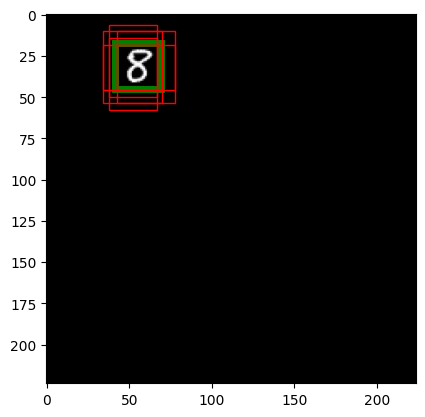

In [25]:
# checking if the inputs prepared are correct or not
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

im = np.array(Img.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

# find all boxes where class label is not background
idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]
print('Number of boxes with IoU > threshold (0.5):',idx.shape[0])
print('Green box: ground truth. Red box: default boxes with IoU < threshold (0.5)')

#calculating the ground truth bounding boxes
gt = np.zeros(4,dtype=np.uint16)
gt[:2] = (img_y[idx[0],1:3] + centres[idx[0],:2])
gt[2:] = (img_y[idx[0],3:] + hw[idx[0],:])

# for some reason, x and y are inverted
rect = patches.Rectangle((gt[1]-gt[3]/2,gt[0]-gt[2]/2),gt[3],gt[2],linewidth=5,edgecolor='g',facecolor='none')
ax.add_patch(rect)

# showing all the boxes with IoU > 0.5
for i in idx:
  rect = patches.Rectangle((centres[i][1]-hw[i,1]/2,centres[i][0]-hw[i,0]/2),hw[i,1],hw[i,0],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

plt.show()

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))
(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))


In [28]:
train_x.shape, train_y.shape

((600, 224, 224, 3), (600, 3150, 5))

In [29]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)

# LOSS FUNCTION<br>
Hard negative mining hasn't been done here<br>
Initial idea was to assign weights to background classes, but there is some problem in that approach

In [30]:
# label is not required here in the standard implementation
# calculate the smooth L1 loss
def smoothL1(x,y,label):
  diff = K.abs(x-y) #* K.switch(label == 10, label*1.0/BOXES, label)
  result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)
  return K.mean(result)

In [31]:
def confidenceLoss(y,label):
  unweighted_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
  # class_weights = tf.constant([[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0/BOXES]]*BOXES])
  # weights = tf.reduce_sum(class_weights * y, axis = -1)
  # weighted_loss = unweighted_loss * weights
  return K.mean(unweighted_loss)

In [32]:
def Loss(gt,y):
  # shape of y is n * BOXES * output_channels
  # shape of gt is n * BOXES * 5 
  loss = 0
  # localisation loss
  loss += smoothL1(y[:,:,-4:],gt[:,:,-4:],gt[:,:,0:1])
  # confidence loss
  loss += confidenceLoss(y[:,:,:-4],tf.cast(gt[:,:,0],tf.int32))
  return loss

# Train model

In [34]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),loss=Loss)

/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv (Conv2D)               (None, 111, 111, 32)      864       
                                                                 
 BN (BatchNormalization)     (None, 111, 111, 32)      128       
                                                                 
 ReLU (ReLU)                 (None, 111, 111, 32)      0         
                                                                 
 Bottleneck_B1_1 (Bottleneck  (None, 111, 111, 16)     2144      
 )                                                               
                                                                 
 Bottleneck_B2_1 (Bottleneck  (None, 56, 56, 24)       5568      
 )                                                         

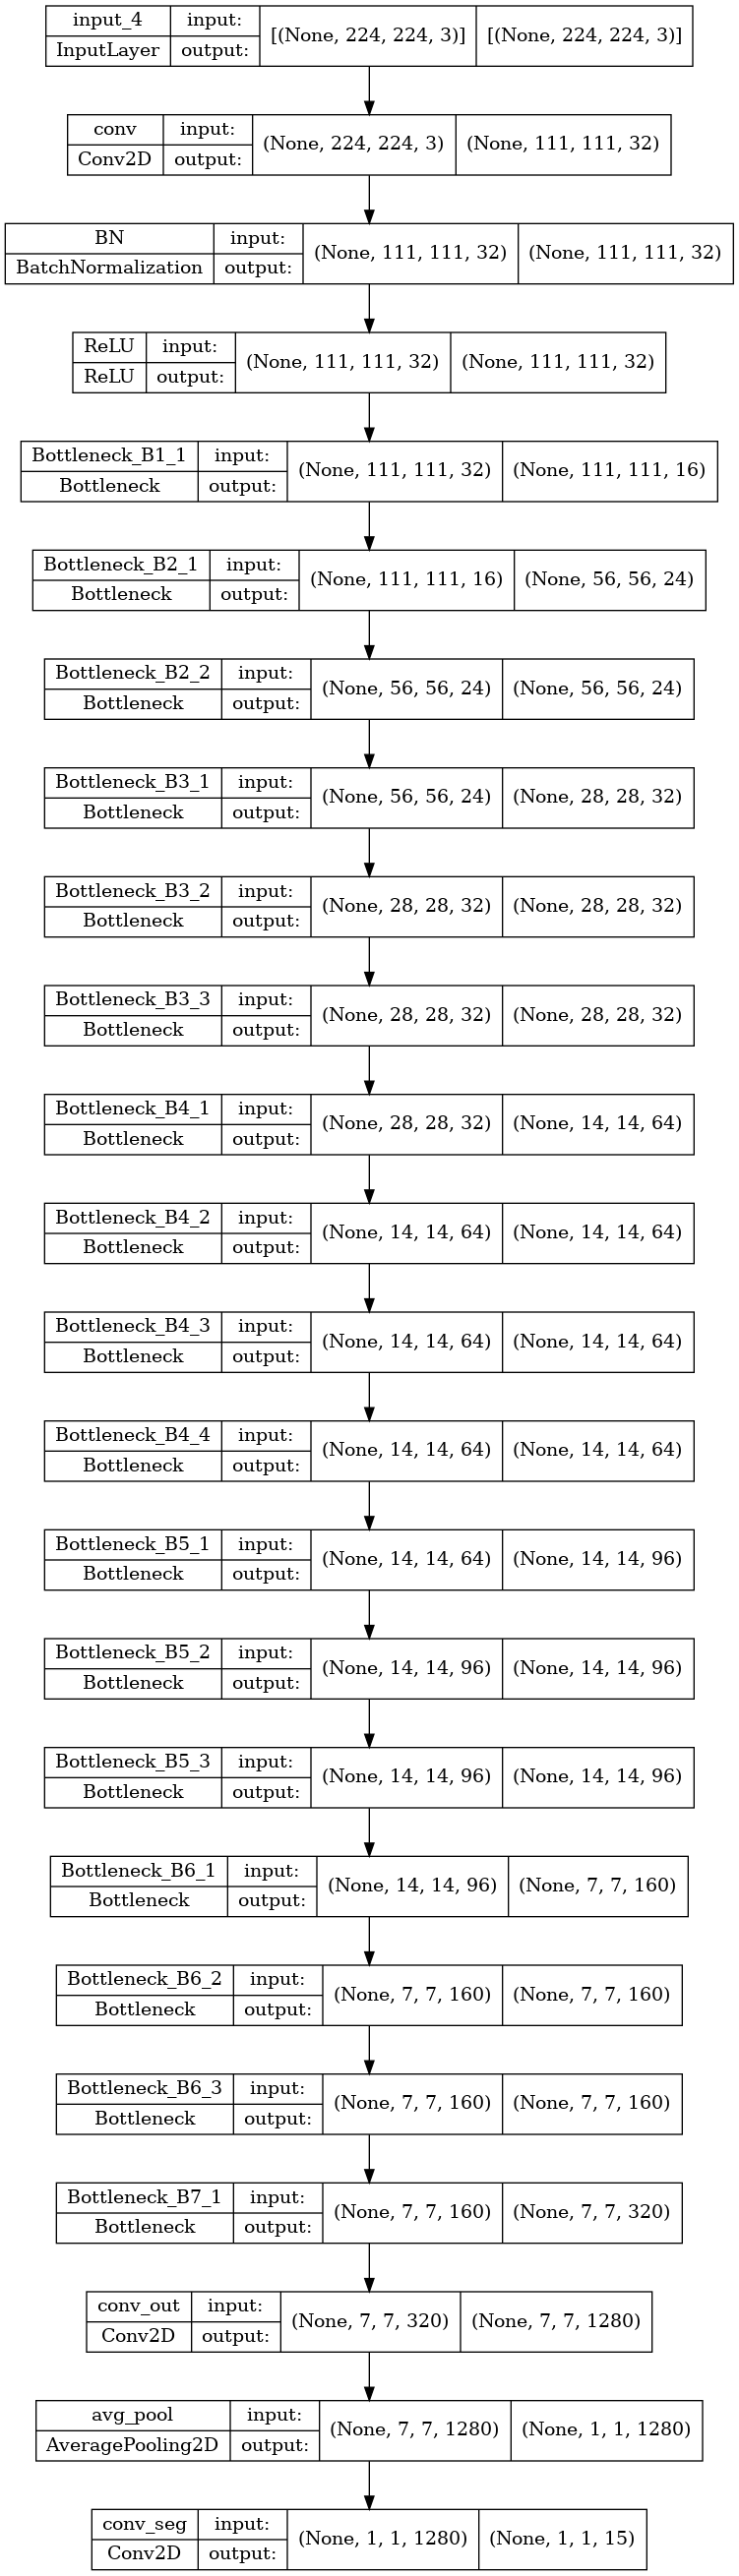

In [36]:
model_mobilenet = model.MobileNet.model()
model_mobilenet.summary()

my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=10),]
model.compile(loss=Loss,optimizer="rmsprop")


projectname = "MobileNetv2"
filename = projectname+'.png'
plot_model(model_mobilenet, to_file=filename, show_shapes=True, show_layer_names=True)

display(Image.open(filename))

In [37]:
EPOCH=200
history = model.fit(train_dataset,
                    epochs=EPOCH,
                    callbacks= [my_callbacks],
                    validation_data = test_dataset)

Train on 18 steps, validate on 3 steps
Epoch 1/200
18/18 [==============================] - ETA: 0s - batch: 8.5000 - size: 1.0000 - loss: 1.0227

/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


18/18 [==============================] - 9s 278ms/step - batch: 8.5000 - size: 1.0000 - loss: 1.0227 - val_loss: 1.7168
Epoch 2/200
18/18 [==============================] - 4s 207ms/step - batch: 8.5000 - size: 1.0000 - loss: 0.1059 - val_loss: 1.0029
Epoch 3/200
18/18 [==============================] - 4s 210ms/step - batch: 8.5000 - size: 1.0000 - loss: 0.0801 - val_loss: 0.5281
Epoch 4/200
18/18 [==============================] - 4s 204ms/step - batch: 8.5000 - size: 1.0000 - loss: 0.1167 - val_loss: 0.2304
Epoch 5/200
18/18 [==============================] - 4s 204ms/step - batch: 8.5000 - size: 1.0000 - loss: 0.0552 - val_loss: 0.1107
Epoch 6/200
18/18 [==============================] - 4s 207ms/step - batch: 8.5000 - size: 1.0000 - loss: 0.0711 - val_loss: 1.3443
Epoch 7/200
18/18 [==============================] - 4s 210ms/step - batch: 8.5000 - size: 1.0000 - loss: 0.1474 - val_loss: 0.0519
Epoch 8/200
18/18 [==============================] - 4s 208ms/step - batch: 8.5000 - siz

In [41]:
model.evaluate(test_x,test_y)

0.010338722448796033

In [46]:
model_original = model

## Train automodel (Random)

In [35]:

def maybe_compute_model_size(model):
    """Compute the size of a given model, if it has been built."""
    if model.built:
        params = [keras.backend.count_params(p) for p in model.trainable_weights]
        return int(np.sum(params))
    return 0


In [33]:
test_x, test_y = convert(x_test,y_test)
train_x, train_y = convert(x_train,y_train)

Trial 50 Complete [00h 03m 41s]
val_loss: 0.011874633692204952

Best val_loss So Far: 0.007313231974840164
Total elapsed time: 03h 24m 24s
Results summary
Results in mytest_dir_mobilenet_ssd_auto1/MobileNetV2RandomAuto
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 2
num_repl4_4: 2
num_repl5_3: 1
num_repl6_3: 2
Score: 0.007313231974840164
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 2
num_repl5_3: 1
num_repl6_3: 1
Score: 0.007557526901364326
Trial summary
Hyperparameters:
learning_rate: 0.01
num_repl3_3: 2
num_repl4_4: 3
num_repl5_3: 1
num_repl6_3: 2
Score: 0.007880479656159877
Trial summary
Hyperparameters:
learning_rate: 0.01
num_repl3_3: 3
num_repl4_4: 2
num_repl5_3: 1
num_repl6_3: 3
Score: 0.008084064573049545
Trial summary
Hyperparameters:
learning_rate: 0.01
num_repl3_3: 1
num_repl4_4: 2
num_repl5_3: 1
num_repl6_3: 1
Score: 0.008392818421125412
Trial summary
Hyperparameters:
learning_rate: 0.001
num_rep

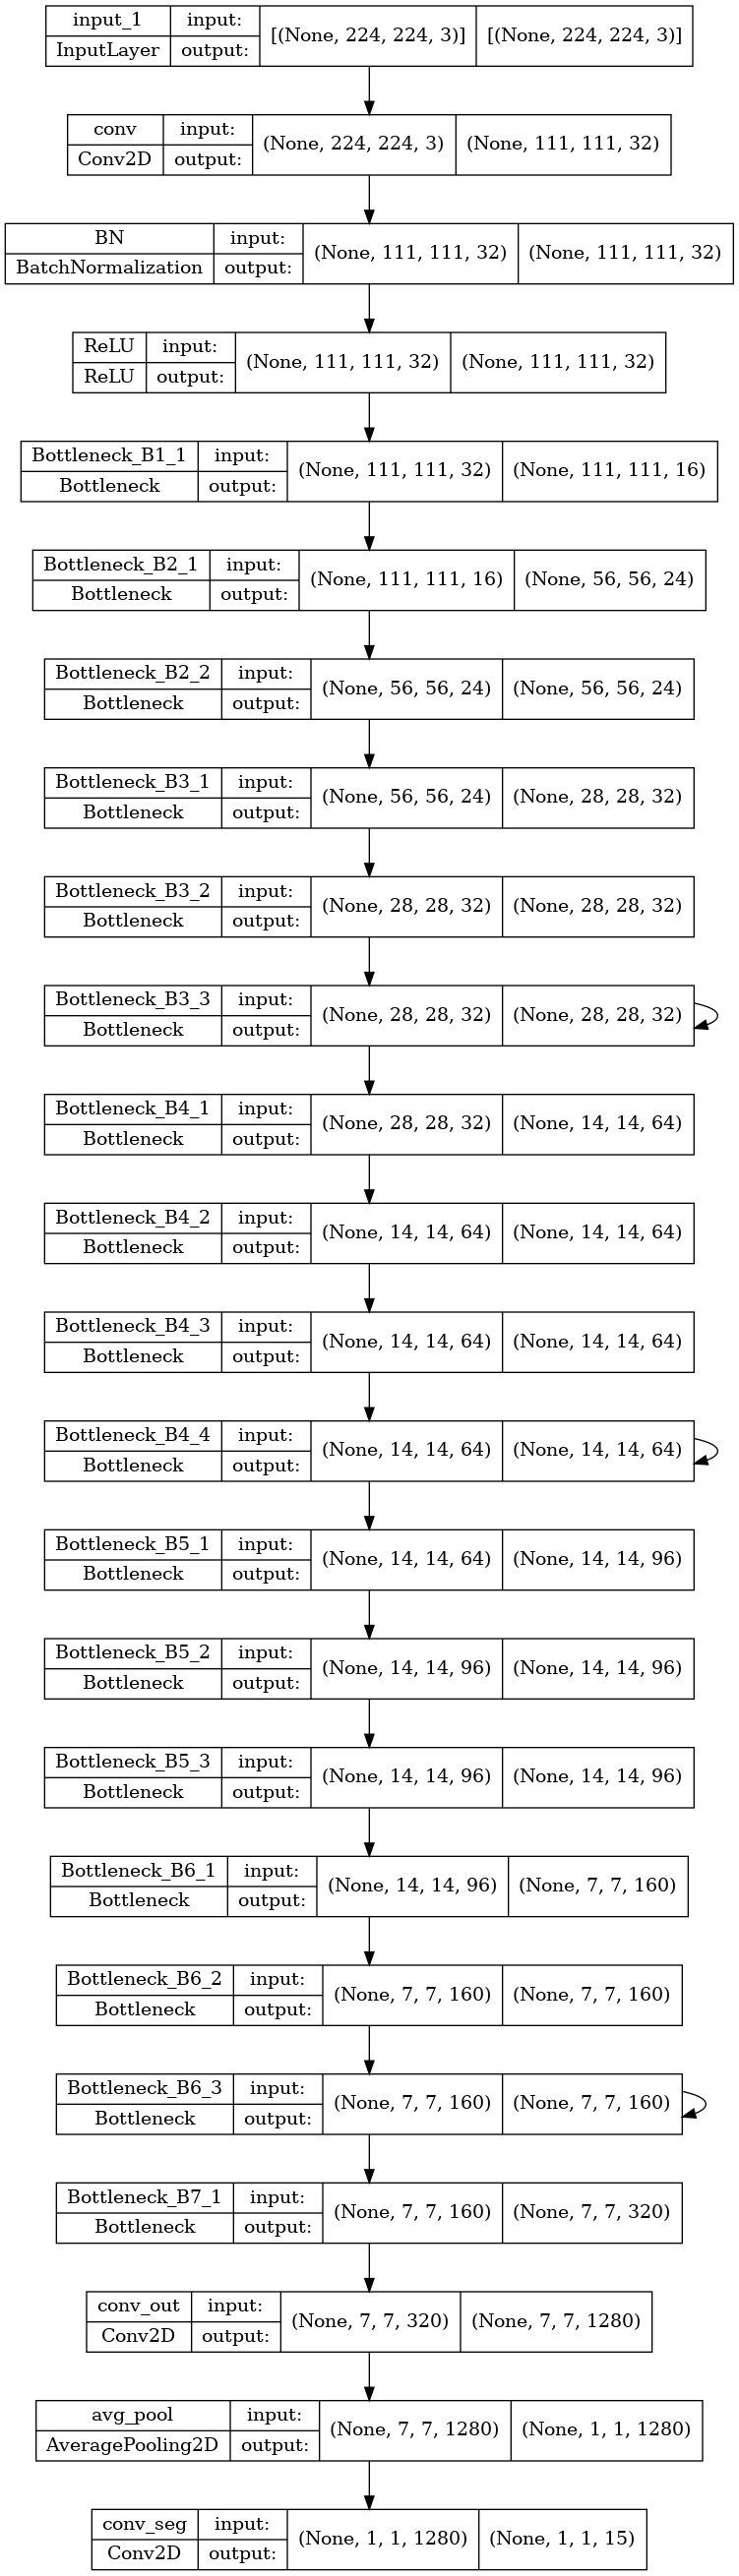

eval loss:


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2.4112760543823244
model size:
3492494
MobileNetV2RandomAuto1.png


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

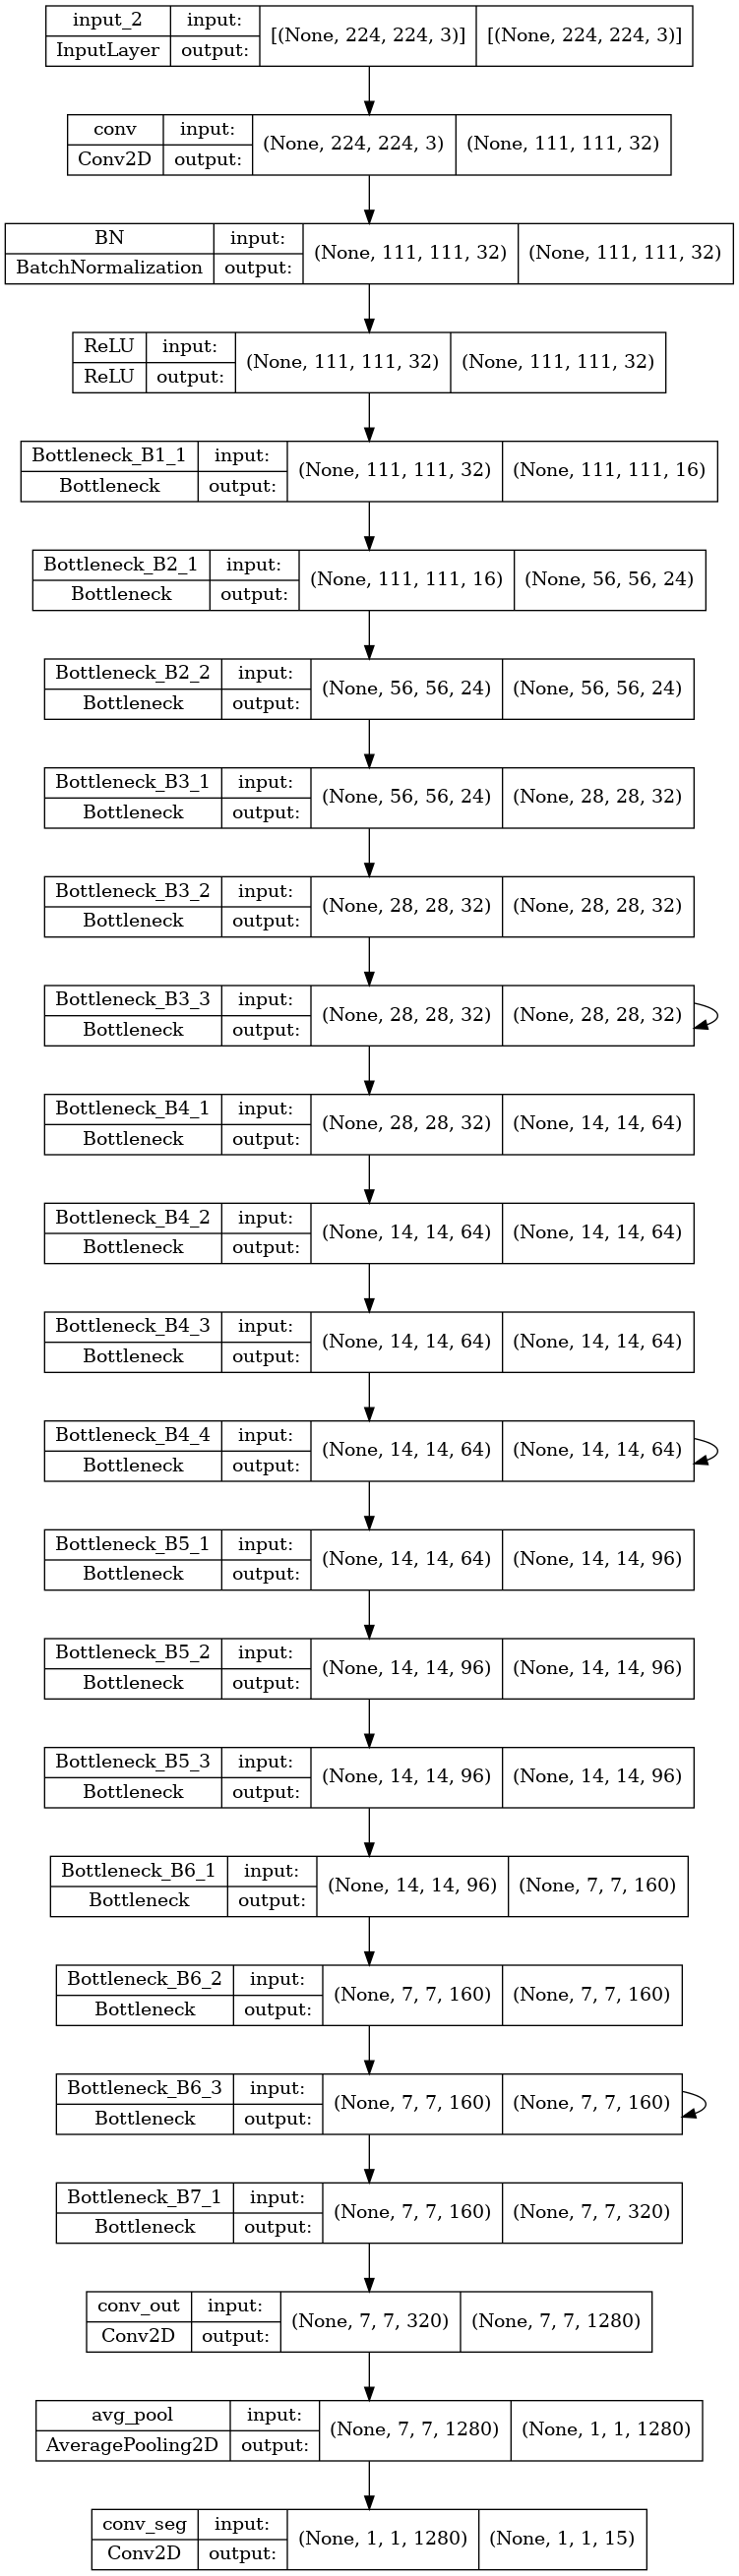

eval loss:


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2.4112751865386963
model size:
3492494
MobileNetV2RandomAuto2.png


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

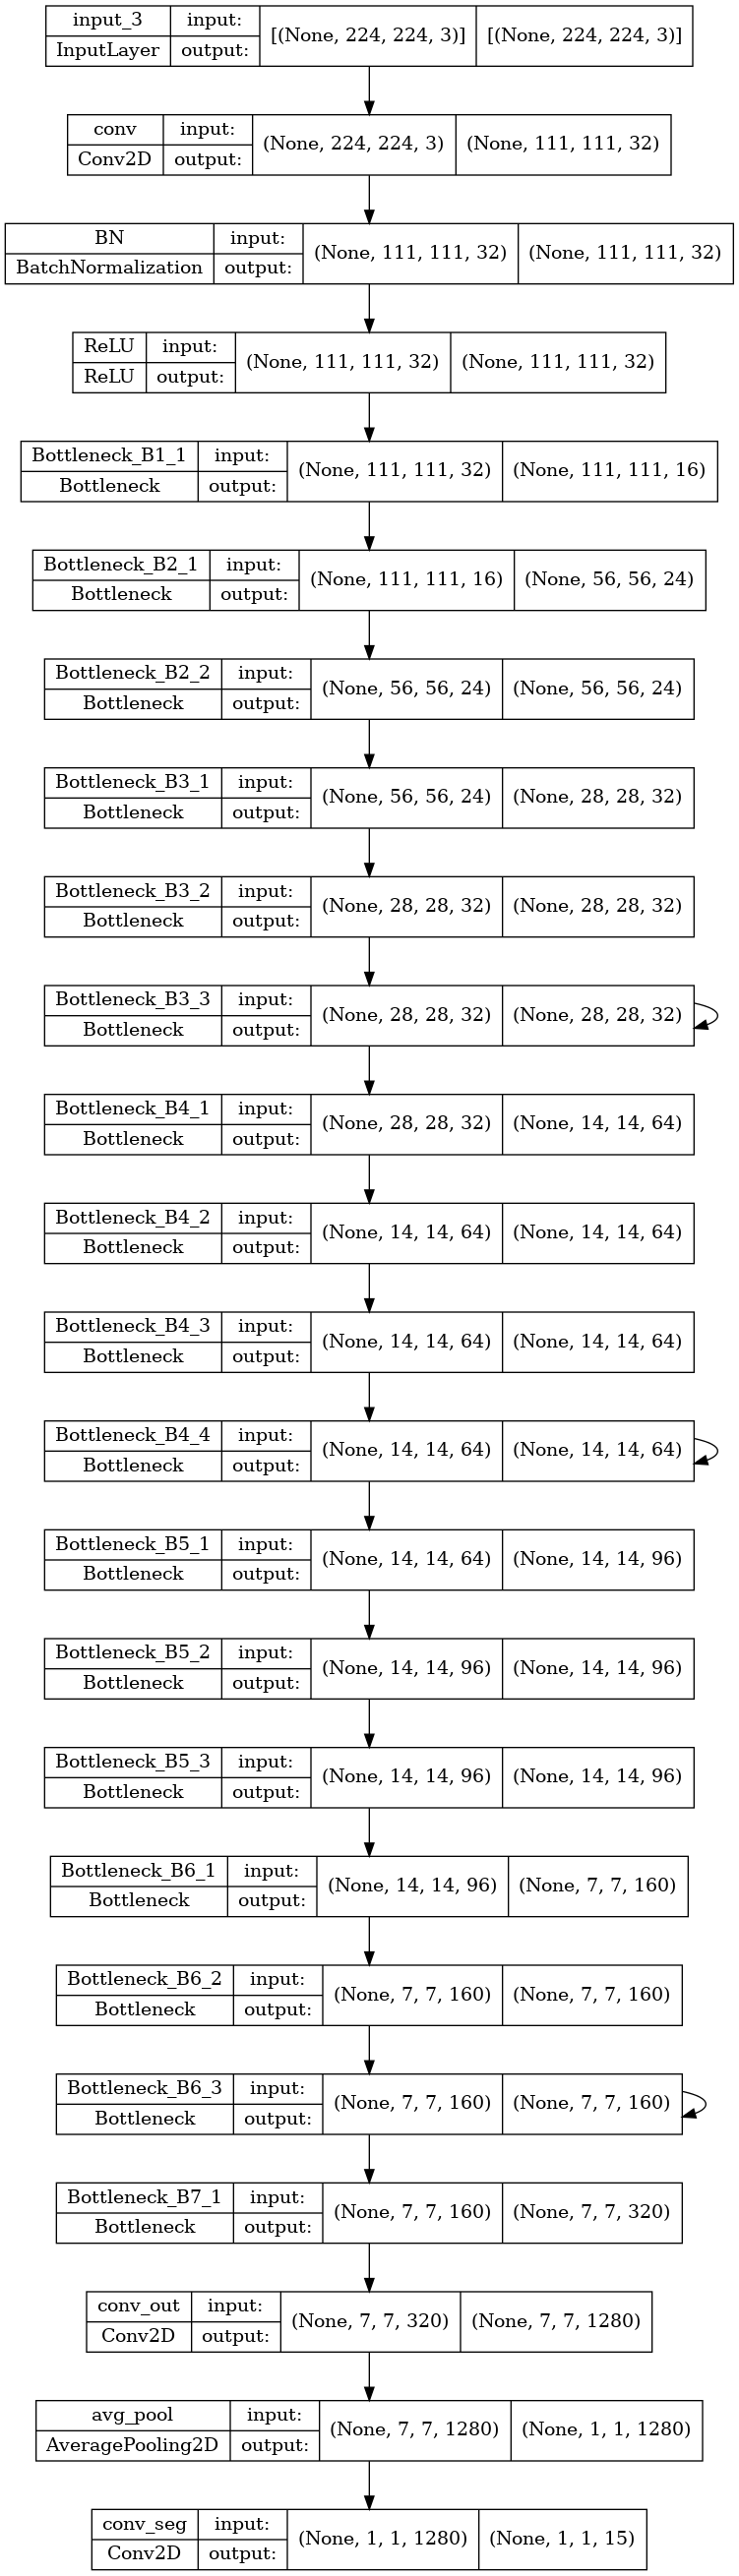

eval loss:


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2.411275110244751
model size:
3492494
eval loss:


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


2.411276550292969
model size:
3492494
eval loss:
2.411277561187744
model size:
3492494
eval loss:
2.411274871826172
model size:
3492494
eval loss:
2.4112773513793946
model size:
3492494
eval loss:
2.411275100708008
model size:
3492494
eval loss:
2.4112767601013183
model size:
3492494
eval loss:
2.4112760639190673
model size:
3492494


In [37]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#SqueezeAuto random
hp = HyperParameters()
# This will override the `learning_rate` parameter with your
# own selection of choices

projectname = "MobileNetV2RandomAuto"
filename = projectname+'.png'

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)



#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 
 
 
tuner = RandomSearch(
     
    build_SSD_MobileAuto1,
    #build_model,
    
    #hypermodel=mymodel,
    hyperparameters = hp,
    objective=Objective("val_loss", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir_mobilenet_ssd_auto1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    #logger = npt_utils.NeptuneLogger(),
     
)
tuner.search_space_summary()


EPOCH = 200
batch_size = BATCH_SIZE
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

#tuner.search(  train_dataset,
#                    epochs=25,
#                    validation_data = test_dataset)
    
tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))
tuner.results_summary()


best_hps = tuner.get_best_hyperparameters(num_trials=10)

for count,best_hp in enumerate(best_hps):
    model = tuner.hypermodel.build(best_hp)
    
    filename = projectname+str(count)+'.png'
    if count < 3:
        print(filename)
        model_mobilenet = model.MobileNet.model()
        model_mobilenet.summary()

        model_mobilenet.compile(loss=Loss,optimizer="rmsprop")


        plot_model(model_mobilenet, to_file=filename, show_shapes=True, show_layer_names=True)

        display(Image.open(filename))

    print('eval loss:')
    print(model.evaluate(test_x,test_y))
    print('model size:')
    print(maybe_compute_model_size(model))

## Train automodel (Baysian)

In [34]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#SqueezeAuto random
hp = HyperParameters()
# This will override the `learning_rate` parameter with your
# own selection of choices

projectname = "MobileNetV2BayesAuto"
filename = projectname+'.png'

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)


EPOCH = 100
batch_size = BATCH_SIZE

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 
tuner = BayesianOptimization(
    #build_SqueezeNet_11_fixed,
    #build_squeezenet_auto_model,
    #build_model,
    
    build_SSD_MobileAuto1,
    hyperparameters = hp,
    objective=Objective("val_loss", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir_mobilenet_ssd_auto1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    tune_new_entries=True,
    allow_new_entries=True,
   # logger = npt_utils.NeptuneLogger(),
     
)

 

tuner.search_space_summary()


""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

#tuner.search(  train_dataset,
#                    epochs=25,
#                    validation_data = test_dataset)
    
tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))
tuner.results_summary()


best_hps = tuner.get_best_hyperparameters(num_trials=10)

for count,best_hp in enumerate(best_hps):
    model = tuner.hypermodel.build(best_hp)
    
    filename = projectname+str(count)+'.png'
    if count < 3:
        print(filename)
        model_mobilenet = model.MobileNet.model()
        model_mobilenet.summary()

        model_mobilenet.compile(loss=Loss,optimizer="rmsprop")


        plot_model(model_mobilenet, to_file=filename, show_shapes=True, show_layer_names=True)

        display(Image.open(filename))

    print('eval loss:')
    print(model.evaluate(test_x,test_y))
    print('model size:')
    print(maybe_compute_model_size(model))

Trial 50 Complete [00h 04m 40s]
val_loss: 0.00958478543907404

Best val_loss So Far: 0.007039031013846397
Total elapsed time: 02h 56m 14s
Results summary
Results in mytest_dir_mobilenet_ssd_auto1/MobileNetV2BayesAuto
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 3
num_repl5_3: 1
num_repl6_3: 2
Score: 0.007039031013846397
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 1
num_repl5_3: 3
num_repl6_3: 3
Score: 0.007592491339892149
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 3
num_repl5_3: 1
num_repl6_3: 2
Score: 0.007649581413716078
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 3
num_repl5_3: 1
num_repl6_3: 2
Score: 0.007746465038508177
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 3
num_repl5_3: 1
num_repl6_3: 2
Score: 0.008325478062033653
Trial summary
Hyperparameters:
learning_rate: 0.0001
nu

AttributeError: type object 'Image' has no attribute 'open'

/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


MobileNetV2BayesAuto0.png
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                 

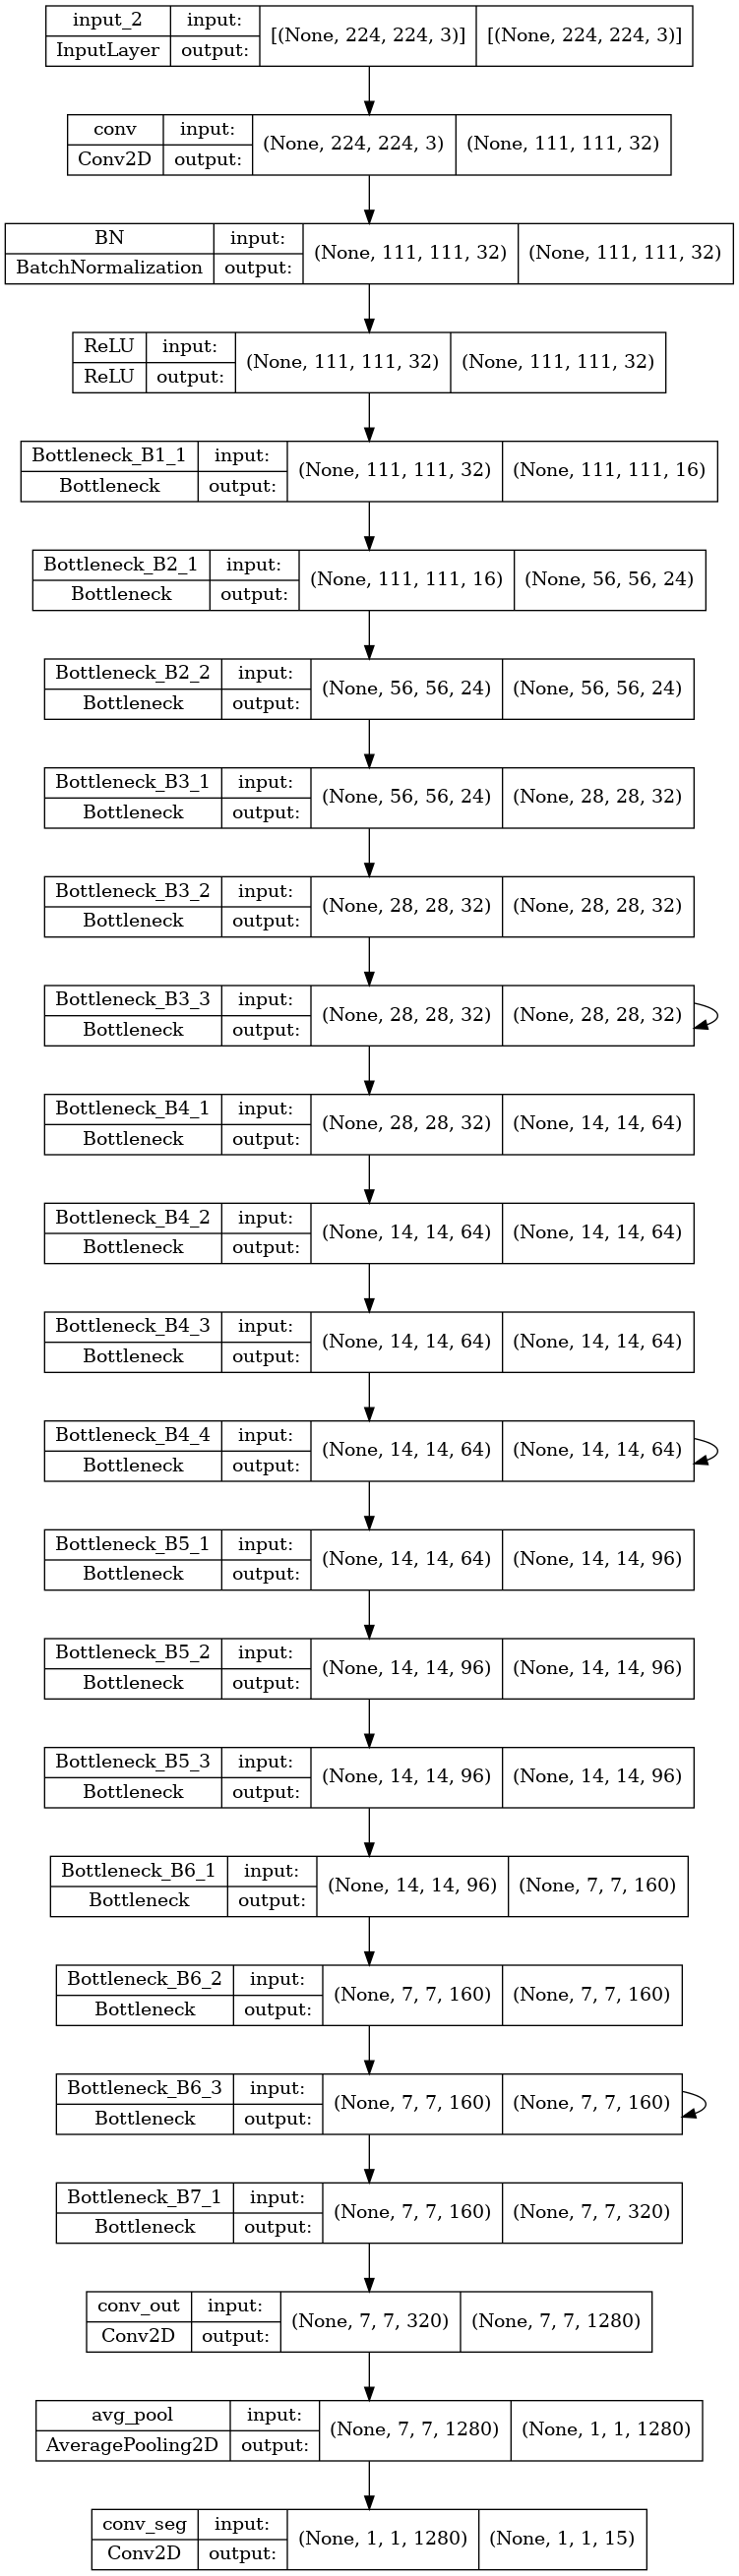

eval loss:
4/4 [==============================] - 0s 31ms/step - loss: 2.4115
2.4114584922790527
model size:
3492494
MobileNetV2BayesAuto1.png


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

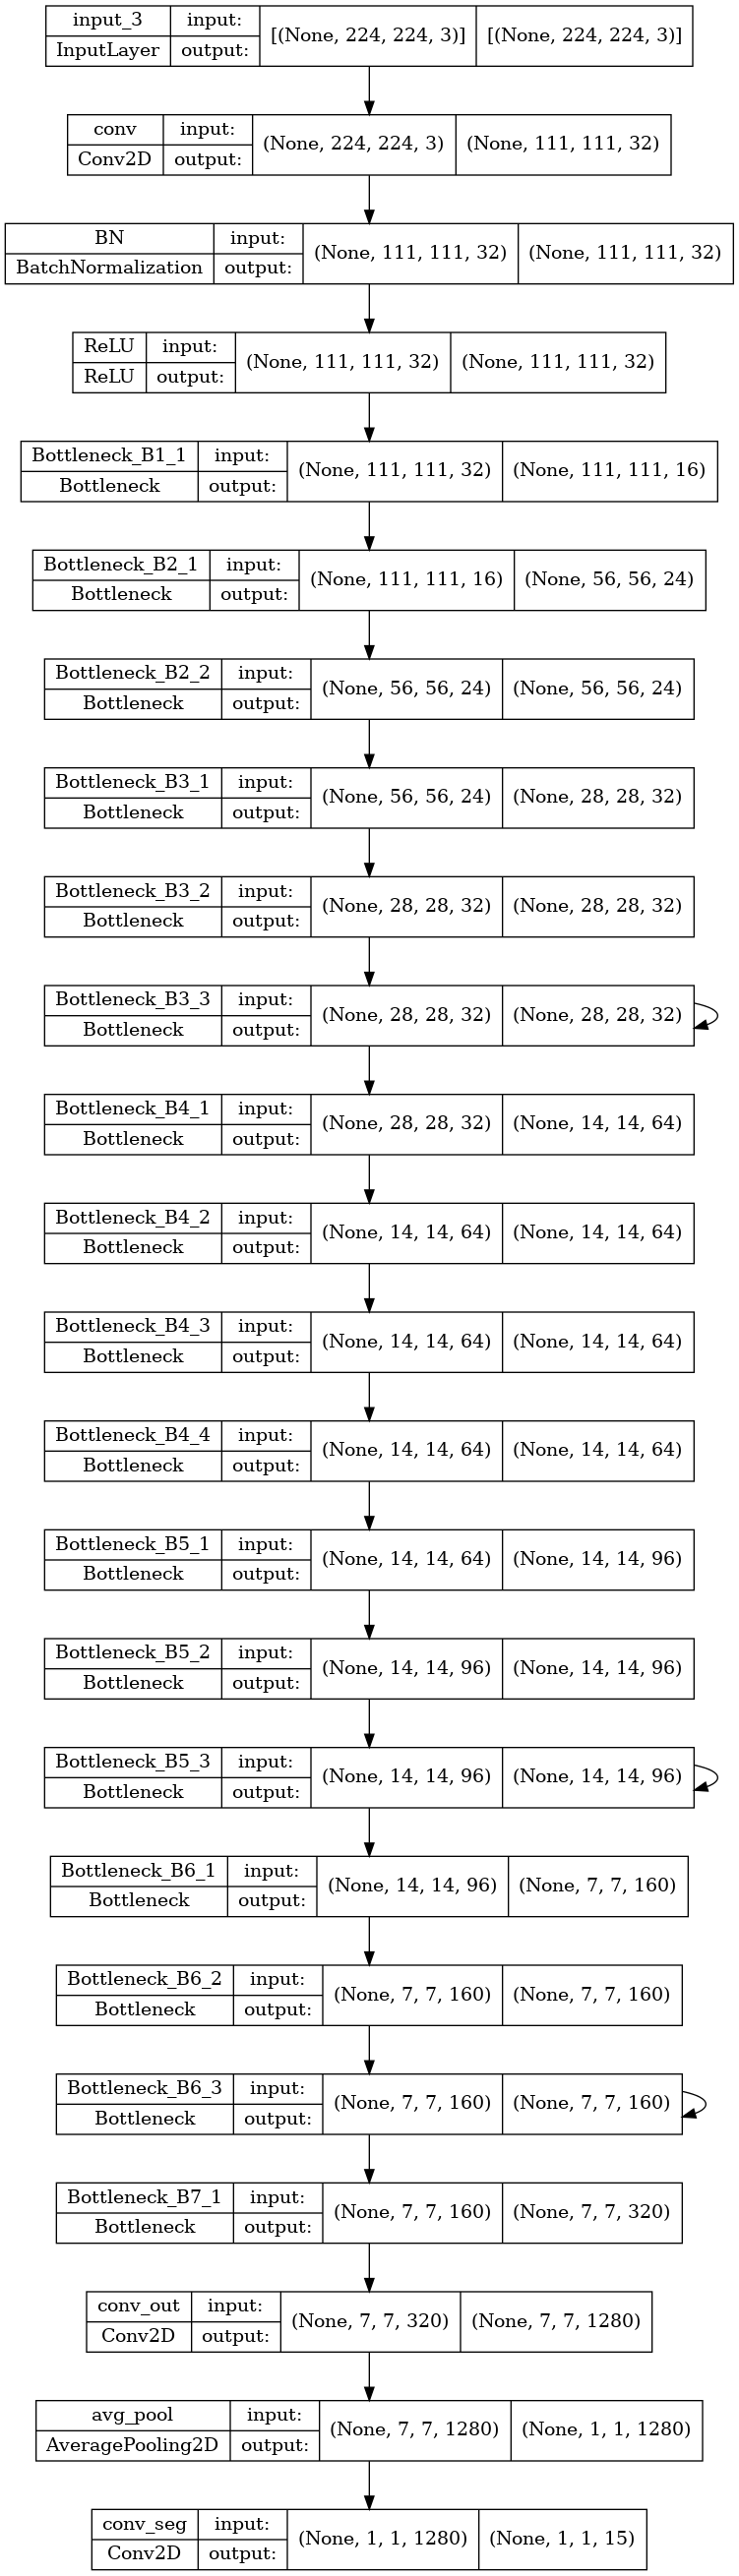

eval loss:
4/4 [==============================] - 0s 32ms/step - loss: 2.4115
2.411459445953369
model size:
3492494
MobileNetV2BayesAuto2.png


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

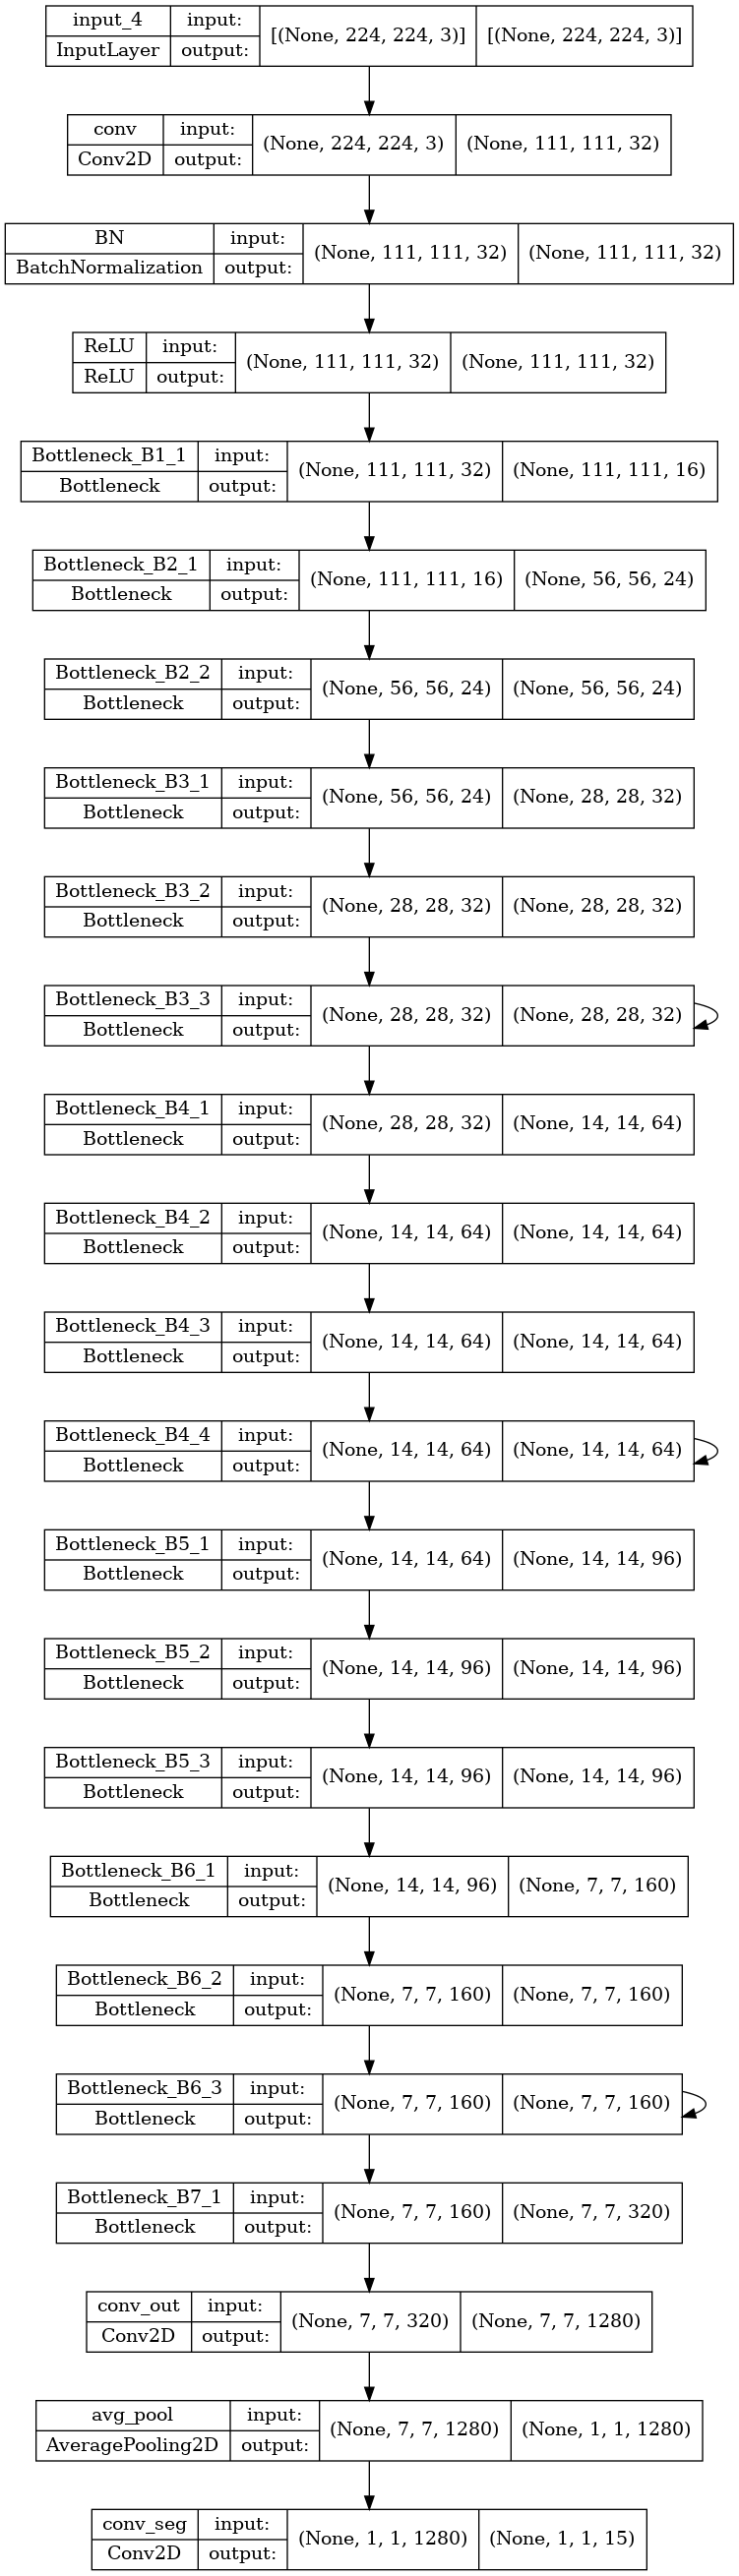

eval loss:
4/4 [==============================] - 0s 32ms/step - loss: 2.4115
2.4114575386047363
model size:
3492494
eval loss:


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


4/4 [==============================] - 0s 30ms/step - loss: 2.4115
2.4114577770233154
model size:
3492494
eval loss:
4/4 [==============================] - 1s 32ms/step - loss: 2.4115
2.411459445953369
model size:
3492494
eval loss:
4/4 [==============================] - 0s 31ms/step - loss: 2.4115
2.4114582538604736
model size:
3492494
eval loss:
4/4 [==============================] - 0s 30ms/step - loss: 2.4115
2.4114575386047363
model size:
3492494
eval loss:
4/4 [==============================] - 0s 30ms/step - loss: 2.4115
2.4114601612091064
model size:
3492494
eval loss:
4/4 [==============================] - 1s 30ms/step - loss: 2.4115
2.4114577770233154
model size:
3492494
eval loss:
4/4 [==============================] - 0s 31ms/step - loss: 2.4115
2.4114553928375244
model size:
3492494


In [35]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)

for count,best_hp in enumerate(best_hps):
    model = tuner.hypermodel.build(best_hp)
    
    filename = projectname+str(count)+'.png'
    if count < 3:
        print(filename)
        model_mobilenet = model.MobileNet.model()
        model_mobilenet.summary()

        model_mobilenet.compile(loss=Loss,optimizer="rmsprop")


        plot_model(model_mobilenet, to_file=filename, show_shapes=True, show_layer_names=True)

        display(Image(filename))

    print('eval loss:')
    print(model.evaluate(test_x,test_y))
    print('model size:')
    print(maybe_compute_model_size(model))

## Train automodel (Hyperband)

In [33]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



#SqueezeAuto random
hp = HyperParameters()
# This will override the `learning_rate` parameter with your
# own selection of choices

projectname = "MobileNetV2HyperbandAuto"
filename = projectname+'.png'

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)

EPOCH = 200

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 
tuner = Hyperband(
    #build_SqueezeNet_11_fixed,
    #build_squeezenet_auto_model,
    #build_model,
    build_SSD_MobileAuto1,
     
    hyperparameters = hp,
    objective=Objective("val_loss", direction="min"),
    #max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir_mobilenet_ssd_auto1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    max_epochs=EPOCH,
    
     
)

 
tuner.search_space_summary()

EPOCH = 100
 
batch_size = BATCH_SIZE
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

#tuner.search(  train_dataset,
#                    epochs=25,
#                    validation_data = test_dataset)
    
tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))
tuner.results_summary()


best_hps = tuner.get_best_hyperparameters(num_trials=10)

for count,best_hp in enumerate(best_hps):
    model = tuner.hypermodel.build(best_hp)
    
    filename = projectname+str(count)+'.png'
    if count < 3:
        print(filename)
        model_mobilenet = model.MobileNet.model()
        model_mobilenet.summary()

        model_mobilenet.compile(loss=Loss,optimizer="rmsprop")


        plot_model(model_mobilenet, to_file=filename, show_shapes=True, show_layer_names=True)

        display(Image.open(filename))

    print('eval loss:')
    print(model.evaluate(test_x,test_y))
    print('model size:')
    print(maybe_compute_model_size(model))

Trial 254 Complete [00h 02m 41s]
val_loss: 0.012700782157480717

Best val_loss So Far: 0.007289145607501268
Total elapsed time: 02h 56m 40s
Results summary
Results in mytest_dir_mobilenet_ssd_auto1/MobileNetV2HyperbandAuto
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_repl3_3: 3
num_repl4_4: 1
num_repl5_3: 2
num_repl6_3: 3
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0237
Score: 0.007289145607501268
Trial summary
Hyperparameters:
learning_rate: 0.01
num_repl3_3: 3
num_repl4_4: 1
num_repl5_3: 2
num_repl6_3: 3
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.007984744384884834
Trial summary
Hyperparameters:
learning_rate: 0.01
num_repl3_3: 2
num_repl4_4: 3
num_repl5_3: 2
num_repl6_3: 3
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0206
Score: 0.0081687206402421
Trial summary
Hyperparameters:
learning_rate: 0.01
n

AttributeError: type object 'Image' has no attribute 'open'

/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


MobileNetV2HyperbandAuto0.png
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                             

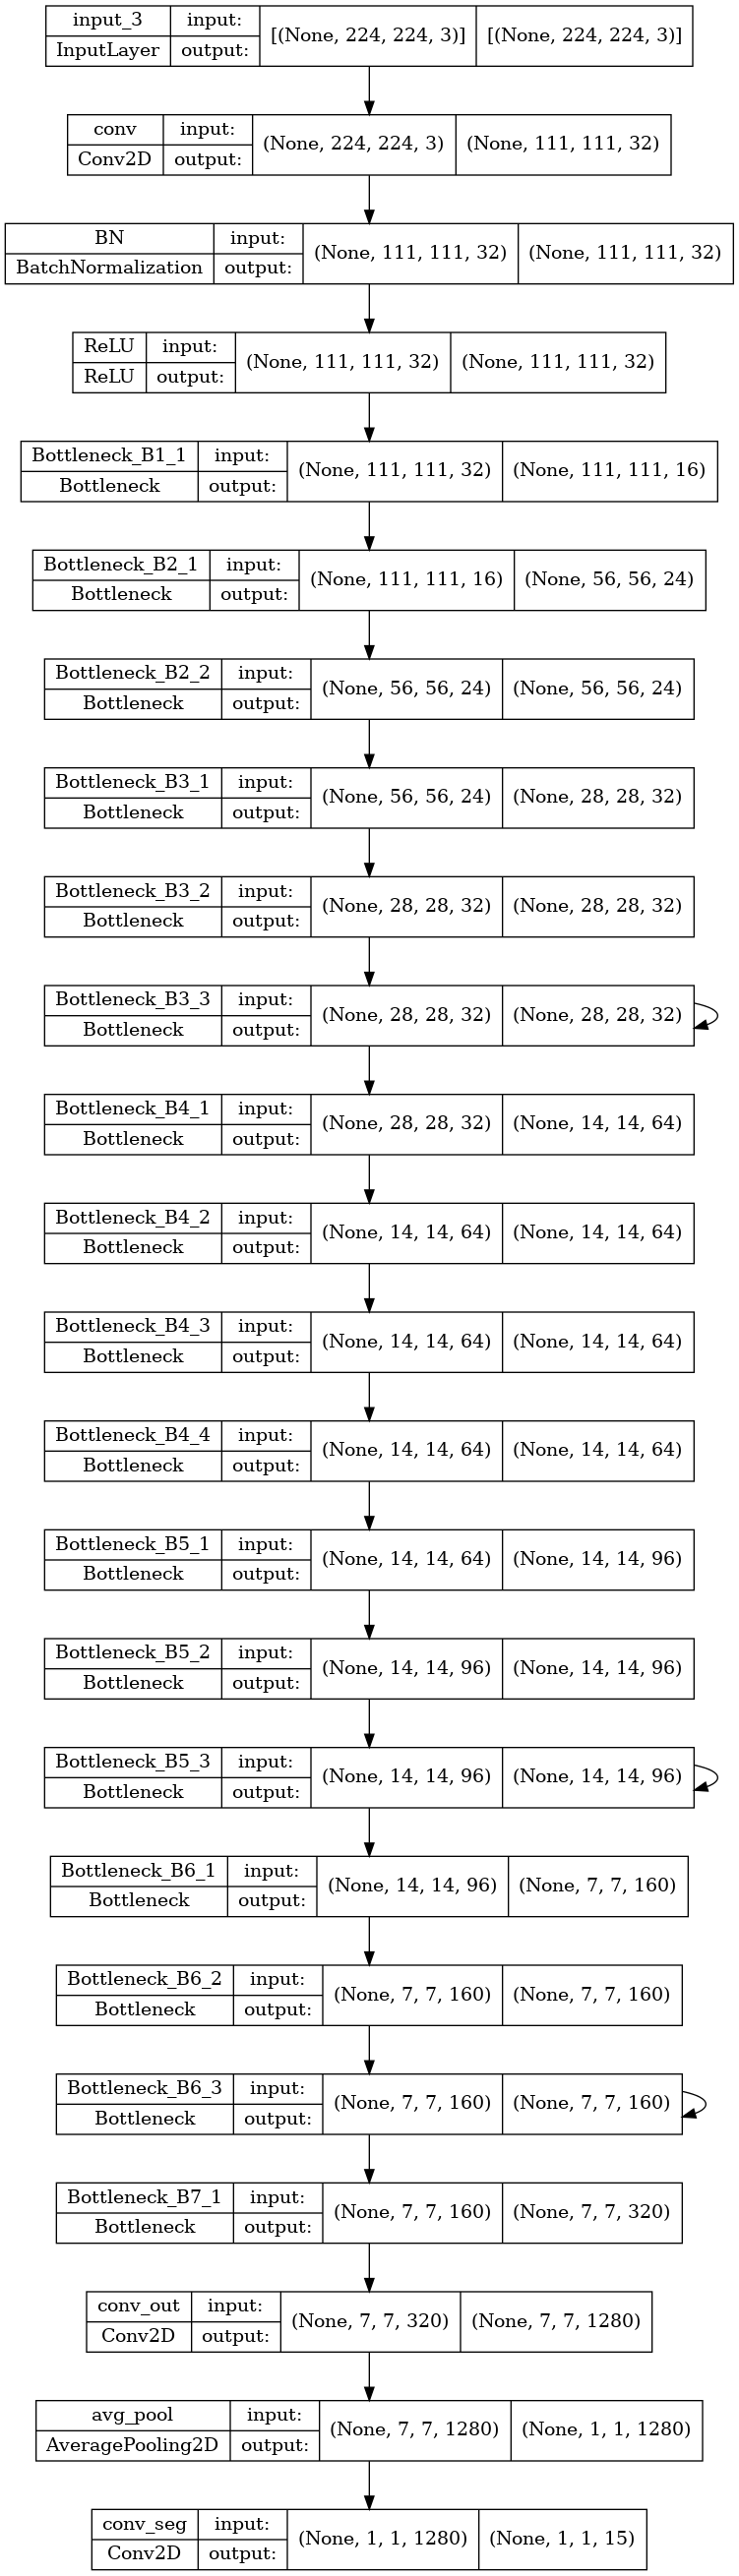

eval loss:
4/4 [==============================] - 1s 31ms/step - loss: 2.4119
2.4119057655334473
model size:
3492494
MobileNetV2HyperbandAuto1.png


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

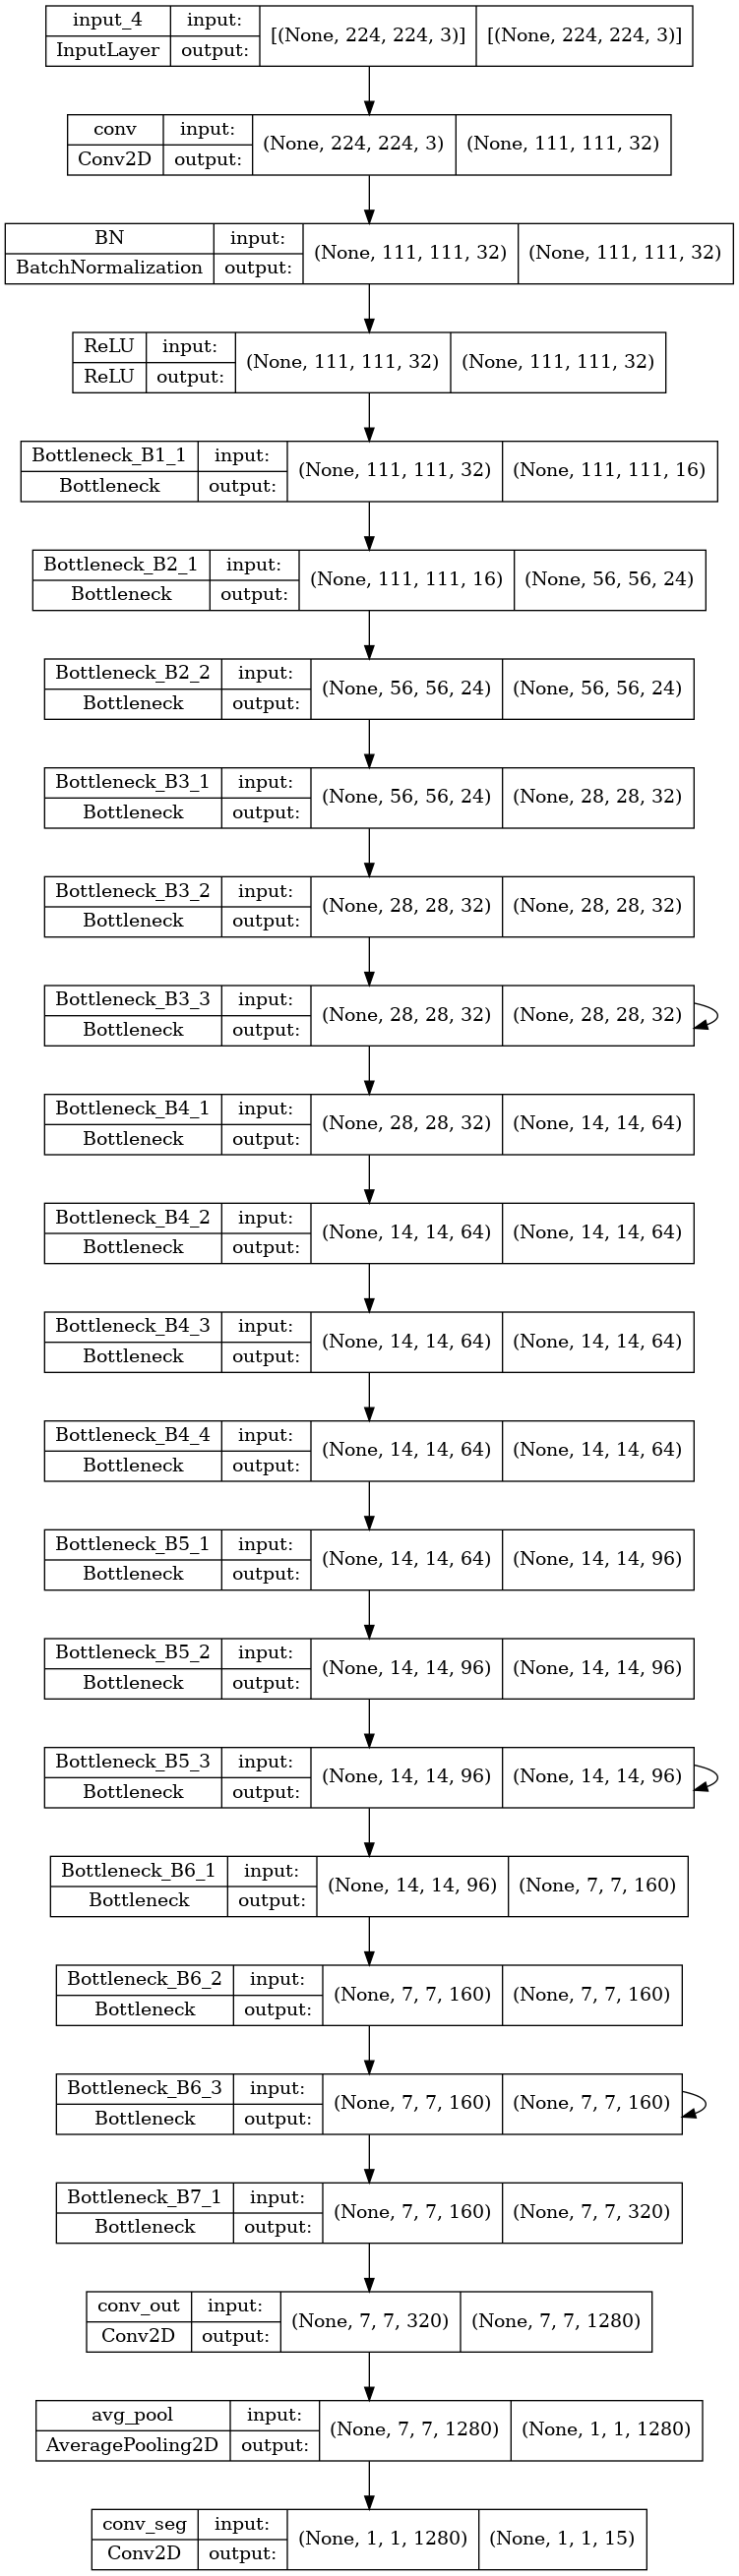

eval loss:
4/4 [==============================] - 0s 31ms/step - loss: 2.4119
2.4119038581848145
model size:
3492494
MobileNetV2HyperbandAuto2.png


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

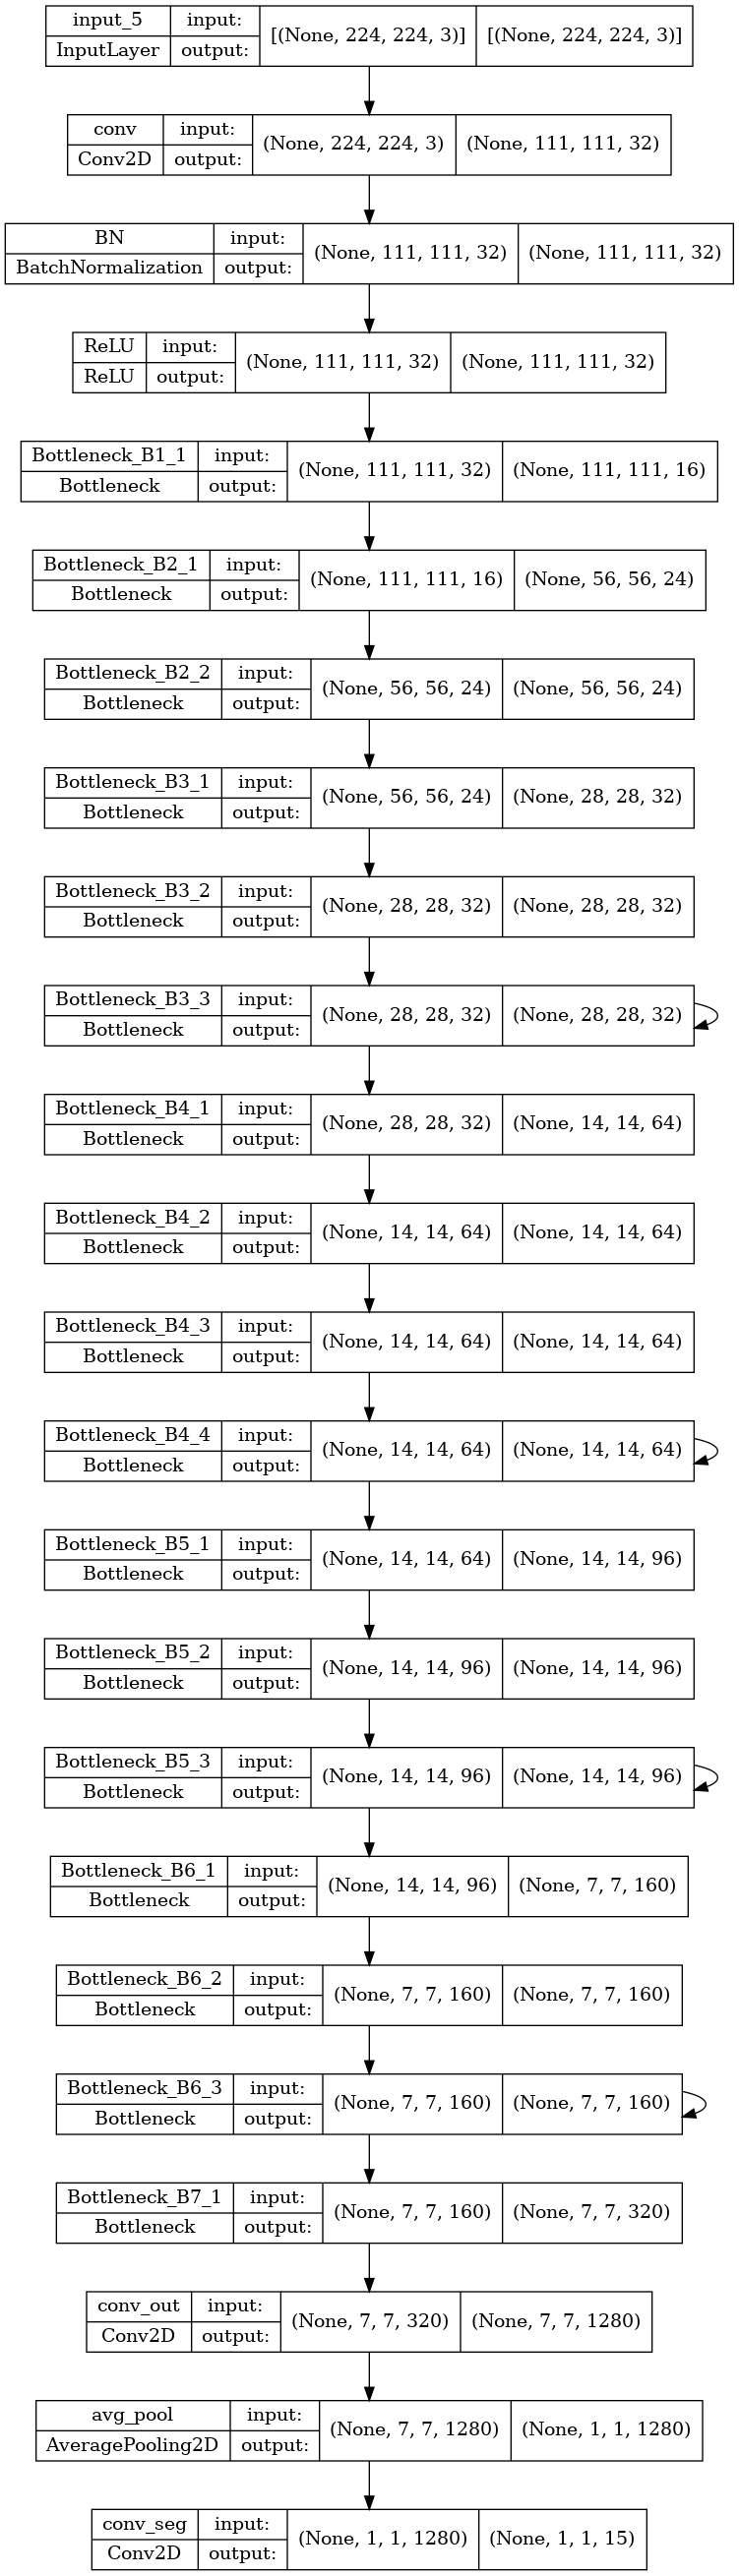

eval loss:
4/4 [==============================] - 0s 31ms/step - loss: 2.4119
2.411905288696289
model size:
3492494
eval loss:


/home/chantana/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 30ms/step - loss: 2.4119
2.411905527114868
model size:
3492494
eval loss:
4/4 [==============================] - 0s 31ms/step - loss: 2.4119
2.411905527114868
model size:
3492494
eval loss:
4/4 [==============================] - 0s 30ms/step - loss: 2.4119
2.4119057655334473
model size:
3492494
eval loss:
4/4 [==============================] - 0s 30ms/step - loss: 2.4119
2.4119069576263428
model size:
3492494
eval loss:
4/4 [==============================] - 0s 29ms/step - loss: 2.4119
2.411907911300659
model size:
3492494
eval loss:
4/4 [==============================] - 0s 29ms/step - loss: 2.4119
2.411907196044922
model size:
3492494
eval loss:
4/4 [==============================] - 0s 28ms/step - loss: 2.4119
2.4119009971618652
model size:
3492494


In [36]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)

for count,best_hp in enumerate(best_hps):
    model = tuner.hypermodel.build(best_hp)
    
    filename = projectname+str(count)+'.png'
    if count < 3:
        print(filename)
        model_mobilenet = model.MobileNet.model()
        model_mobilenet.summary()

        model_mobilenet.compile(loss=Loss,optimizer="rmsprop")


        plot_model(model_mobilenet, to_file=filename, show_shapes=True, show_layer_names=True)

        display(Image(filename))

    print('eval loss:')
    print(model.evaluate(test_x,test_y))
    print('model size:')
    print(maybe_compute_model_size(model))

# INFERENCE from original model

In [42]:
# create some sample data
X, Y = convert(x_test, y_test)

In [47]:
model = model_original

In [49]:
# get prediction for one sample
y_pred = model.predict(X)
y_pred.shape

(100, 3150, 15)

In [50]:
OBJperCLASS = 10 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
  # classes are actually the index into the default boxes
  classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
  conf = np.zeros((OBJperCLASS,outputChannels-4))
  delta = np.zeros((OBJperCLASS,outputChannels-4,4))
  class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
  for i in range(outputChannels-4):
    classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
    conf[:,i] = class_predictions[classes[:,i],i]
    delta[:,i] = Y[classes[:,i],outputChannels-4:]
  return conf,classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
  #delta contains delta(cx,cy,h,w)
  bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
  bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
  for i in range(OBJperCLASS):
    bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
    bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
    bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
    bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
  return bbox_centre,bbox_hw

4
4: Confidence-0.8106910586357117		Centre-[164.78957528  31.66307235] Height,Width-[29.41319701 29.46676394]
4: Confidence-0.8443018198013306		Centre-[164.96012467  35.17142552] Height,Width-[28.11927932 29.95889365]
4: Confidence-0.3496899902820587		Centre-[160.93980122  35.20981956] Height,Width-[35.95283922 28.25709363]
4: Confidence-0.003358609974384308		Centre-[170.89080966  28.71048003] Height,Width-[34.33178267 34.65433475]
4: Confidence-0.6995073556900024		Centre-[165.10149705  37.50369358] Height,Width-[27.42072147 33.78583037]
4: Confidence-0.6934902667999268		Centre-[164.86285633  34.73973274] Height,Width-[28.1993286  30.05983626]
4: Confidence-0.9067331552505493		Centre-[165.30574465  35.05580139] Height,Width-[26.20432266 28.21468522]
4: Confidence-0.9783369898796082		Centre-[167.63634968  34.82710898] Height,Width-[28.61347052 28.49008795]
4: Confidence-0.9455199241638184		Centre-[165.96360052  34.14561856] Height,Width-[28.62955078 27.66315963]
4: Confidence-0.96500623

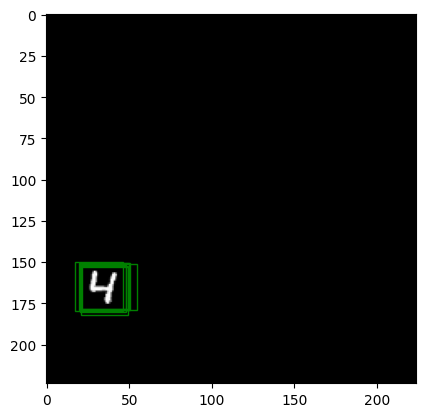

In [51]:
r = np.random.randint(TESTSIZE)

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(X[r].astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # skipping backgrounds
  if i == NUM_CLASSES:
    continue
  color = 'r'
  # if a class is mentioned in the ground truth, color the boxes green
  if i in Y[r,:,0]:
    color = 'g'
    print(i)
  
  # skip all the classes which have low confidence values
  if (confidence[:,i] > 0.5).any() or i in Y[r,:,0]:
    for k in range(OBJperCLASS):
      print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
      
      # draw bounding box only if confidence scores are high
      if confidence[k,i] < 0.5:
        continue
      x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
      y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
      rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
      ax.add_patch(rect)

plt.show()